# Capstone Project - The Battle of Neighborhoods (Week 2)

### Applied Data Science Capstone by IBM/Coursera

## Table of contents

* [Introduction: Business Problem](#Introduction)

* [Data](#Data)

* [Methodology](#Methodology)

* [Results](#Results)

* [Discussion](#Discussion)

* [Conclusion](#Conclusion)

* [References](#References)

## Introduction: Business Problem

As I am currently living in Madrid, I decided to choose this city for my final project in order to make it more personal.

Madrid is the capital and most populous city in Spain. The city has almost 3.3 million inhabitants and a metropolitan area population of approximately 6.5 million covering an area of 4,609.7 square kilometers (1,780 sq mi). It is the second-largest city in the European Union, surpassed only by Berlin.

Madrid is also the political, economic, and cultural center of the country. The Madrid urban agglomeration has the third-largest GDP in the European Union and its influence in politics, education, entertainment, environment, media, fashion, science, culture, and the arts all contribute to its status as one of the world's major global cities.

That is why the Spanish capital is so attractive for foreign and local investors which means that the market is highly competitive. And the cost of housing is also one of the highest - in terms of a real estate property Madrid is considered as one of the most expensive cities in Spain.

One of the reasons for choosing a real estate property could be the price as well as the social establishments. In this project, I will examine neighborhoods of Madrid by average price per square meter for second-hand housing in April 2020 and cluster them according to the venues density. The analysis will give an understanding not only about a cost but also the most popular venues in certain areas and will be useful to anyone who is interested in investing in property in Madrid.

## Data

To solve the problem I use the following data:

* Average prices of the second-hand housing by square meter in Madrid in April 2020 - collected by neighborhoods from the real estate portal idealista.com and created in a table [[2]](#2)

* Latitude and longitude coordinates of each neighborhood - collected using GeoHack [[3]](#3)

* Top venues of neighborhoods - taken from the Foursquare API [[4]](#4)

* Neighbourhood divisions of Madrid - taken from GitHub and used for creating a choropleth map [[5]](#5)

## Methodology 

Let's read the real estate portal data that gives us information about the average prices of second-hand housing by neighborhoods in Madrid.

But first we need to import all the dependencies.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
data = pd.read_excel(r"C:\Users\...\Barrios_Madrid.xlsx")
data.head()

,Unnamed: 0,Localización,Precio m2 abr 2020,Variación mensual,Variación trimestral,Variación anual,Máximo histórico,Variación máximo
0,Arganzuela,Acacias,3.920 €/m2,-0.018,-0.064,-0.056,4.273 €/m2 dic 2018,-0.083
1,Arganzuela,Chopera,3.578 €/m2,-0.001,-0.013,-0.047,3.843 €/m2 jun 2019,-0.069
2,Arganzuela,Delicias,3.809 €/m2,0.008,-0.024,-0.092,4.193 €/m2 abr 2019,-0.092
3,Arganzuela,Imperial,4.099 €/m2,0.030,0.045,-0.005,4.171 €/m2 feb 2019,-0.017
4,Arganzuela,Legazpi,4.436 €/m2,-0.010,0.010,-0.013,4.714 €/m2 jun 2019,-0.059


Let's clean the data set

In [3]:
# divides 'Precio m2 abr 2020' in two columns to get rid of €/m2
data[['Price','m2']] = data['Precio m2 abr 2020'].str.split(expand=True) 
# drops the columns that we are not going to use for the analysis
data = data.drop(columns=['Precio m2 abr 2020', 'm2', 'Variación mensual', 
                          'Variación trimestral', 'Variación anual', 'Máximo histórico', 'Variación máximo'])
# changes column name
data = data.rename(columns={'Unnamed: 0': 'District', 'Localización': 'Neighborhood'})

# changes names of three districs to their composed names
data['District'] = data['District'].replace({'Fuencarral':'Fuencarral-El Pardo','Moncloa':'Moncloa-Aravaca','San Blas':'San Blas-Canillejas'})

# delets thousand separator
data['Price'] = data['Price'].str.replace('.', '')
# changes dtype of Price column
data['Price'] = data['Price'].astype(int)
data.head()

,District,Neighborhood,Price
0,Arganzuela,Acacias,3920
1,Arganzuela,Chopera,3578
2,Arganzuela,Delicias,3809
3,Arganzuela,Imperial,4099
4,Arganzuela,Legazpi,4436


How many districts and neighborhoods does Madrid have?

In [4]:
print('The dataframe has {} districts and {} neighborhoods.'.format(
        len(data['District'].unique()),
        data.shape[0]
    )
)

The dataframe has 21 districts and 131 neighborhoods.


In [5]:
data.describe()

,Price
count,131.000000
mean,3436.488550
std,1351.452002
min,1400.000000
25%,2309.000000
50%,3252.000000
75%,4243.000000
max,8440.000000


We can find average price per square meter in Madrid in April 2020.

In [6]:
print('Average price per m2 is:')
print(round(data[['Price']].mean(), 0))

Average price per m2 is:
Price    3436.0
dtype: float64


And also neighborhoods with maximum and minimum price per square meter.

In [7]:
print('Max price per m2:')
df1=data[['District','Neighborhood','Price']][data.Price == data['Price'].max()]
print(df1)

print('Min price per m2:')
df1=data[['District','Neighborhood','Price']][data.Price == data['Price'].min()]
print(df1)

Max price per m2:
     District Neighborhood  Price
97  Salamanca    Recoletos   8440
Min price per m2:
       District   Neighborhood  Price
130  Villaverde  San Cristobal   1400


We can use choropleth map for better visualization.

In [8]:
from urllib.request import urlopen

with urlopen('https://gist.githubusercontent.com/Saigesp/8ca8ca2a4ce33e8e9efe8f5752683f88/raw/81d61ae9a410a59cb512dd7b01ba9bd5c98c8380/ESP_MAD_adm6.json') as response:
    neigh = json.load(response)

In [15]:
madrid_map = folium.Map(location=[40.4167047, -3.7035825], zoom_start=10.5, tiles='Mapbox Bright')

In [16]:
madrid_map.choropleth(
    geo_data=neigh,
    data=data,
    columns=['Neighborhood', 'Price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Housing sale price in Madrid in April 2020',
    highlight=True
)

madrid_map

We can also visualize average prices per district.

In [32]:
districts = data.groupby('District', as_index=False)['Price'].mean().sort_values('Price')

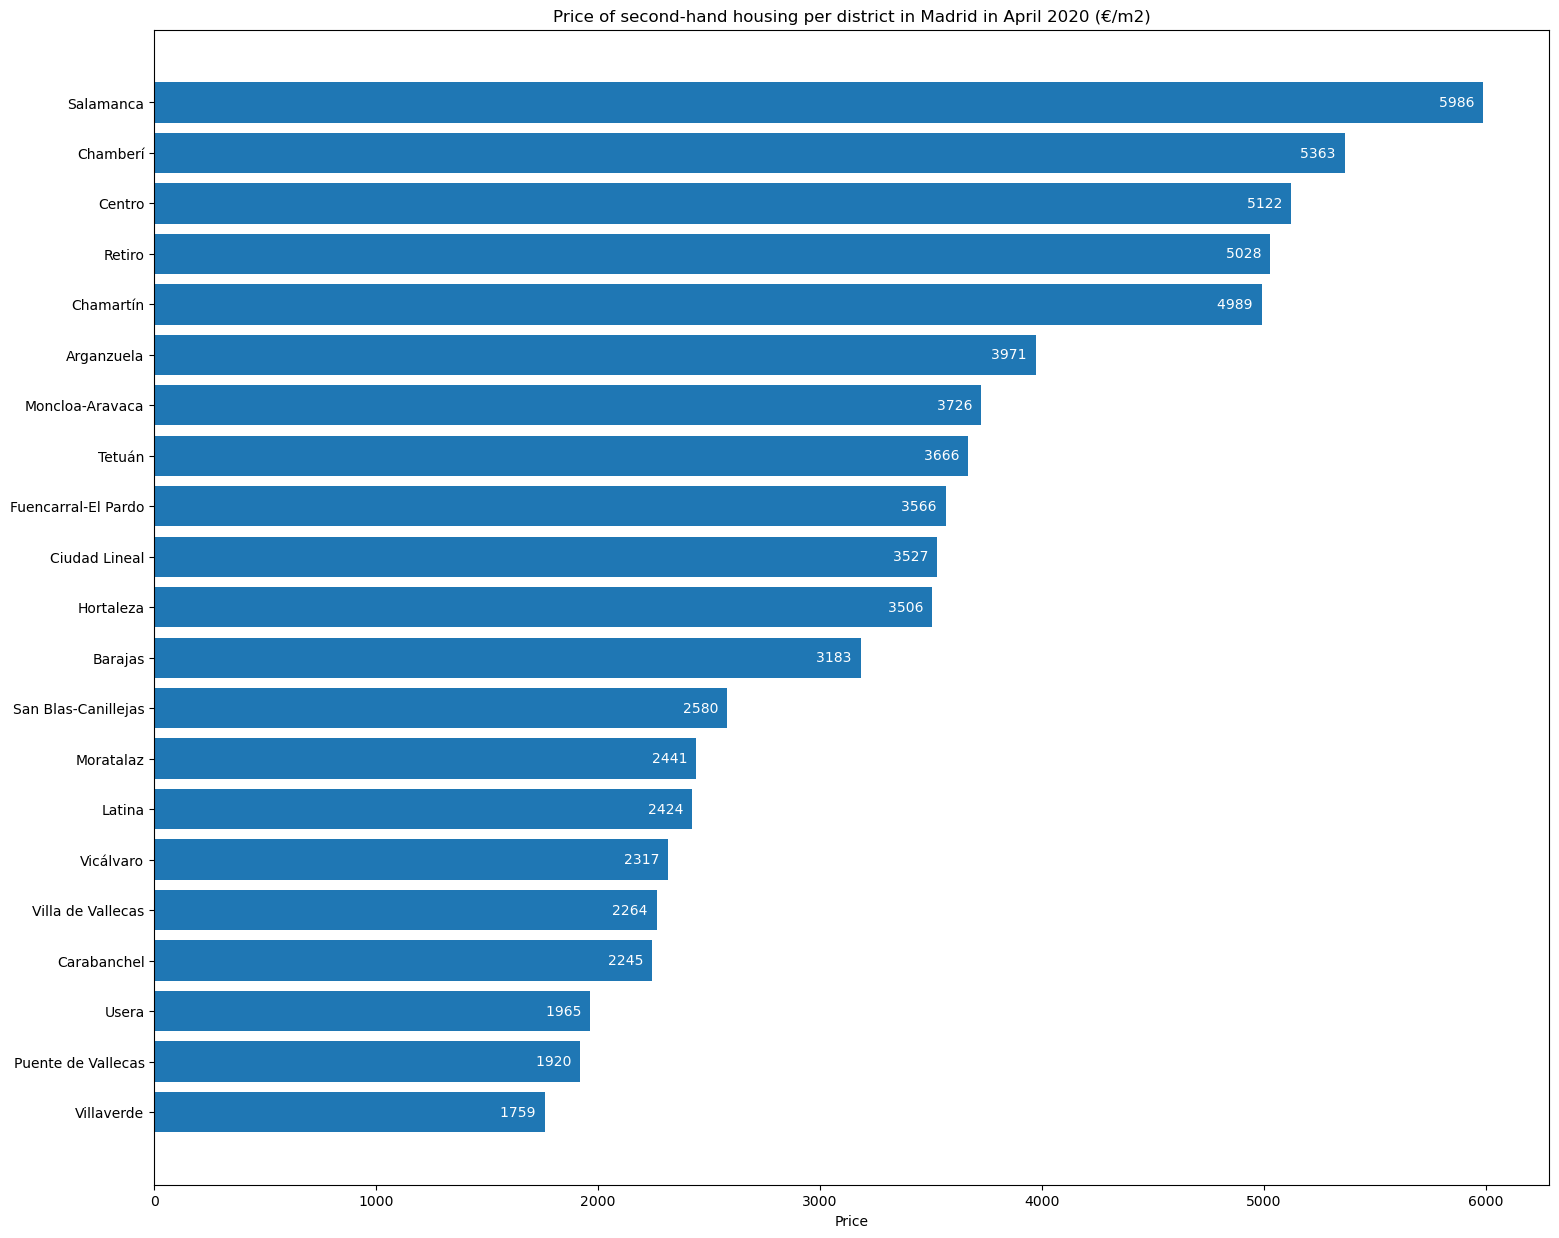

In [33]:
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

plt.rcdefaults()
plt.rcParams["figure.figsize"] = (18,15)
fig, ax = plt.subplots()

# Example data
y_labels = districts['District'].values
price = districts['Price'].values.astype('int32')


y_pos = np.arange(len(y_labels))


ax.barh(y_pos, price,  align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Price')
ax.set_title('Price of second-hand housing per district in Madrid in April 2020 (€/m2)')


#Show the labels
for i, v in enumerate(price):
    ax.text(v, i,  str(v)+"  ", va='center', ha="right", color='White')

### Get the latitude and the longitude coordinates of each neighborhood

In [34]:
geo = pd.read_excel(r"C:\Users\...\geo_Madrid.xlsx")
geo.head()

,Neighborhood,Latitude,Longitude
0,Acacias,40.401422,-3.704936
1,Chopera,40.395000,-3.699444
2,Delicias,40.395833,-3.689444
3,Imperial,40.406667,-3.716944
4,Legazpi,40.388611,-3.695178


In [35]:
neighborhoods = pd.merge(geo, data, on='Neighborhood')
neighborhoods = neighborhoods[['District', 'Neighborhood', 'Price', 'Latitude', 'Longitude']]
neighborhoods.head()

,District,Neighborhood,Price,Latitude,Longitude
0,Arganzuela,Acacias,3920,40.401422,-3.704936
1,Arganzuela,Chopera,3578,40.395000,-3.699444
2,Arganzuela,Delicias,3809,40.395833,-3.689444
3,Arganzuela,Imperial,4099,40.406667,-3.716944
4,Arganzuela,Legazpi,4436,40.388611,-3.695178


### Explore the neighborhoods of Madrid

Use geopy library to get the latitude and longitude values of Madrid.

In [36]:
address = 'Madrid'

geolocator = Nominatim(user_agent="m_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Madrid are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Madrid are 40.4167047, -3.7035825.


Create a map of Madrid with neighborhoods superimposed on top.

In [37]:
# create map of Madrid using latitude and longitude values
map_madrid = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['District'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  
    
map_madrid

For illustration purposes, let's suppose our investor is interested in four city center districts such as Centro, Chamberí, Salamanca, and Retiro, and let's simplify the above map and segment and cluster only neighborhoods of the mentioned districts. So let's slice the original data frame and create a new data frame of the city center data.

In [38]:
center_data = neighborhoods[neighborhoods['District'].isin(['Centro', 'Chamberí', 'Salamanca', 'Retiro'])].reset_index(drop=True)
center_data

,District,Neighborhood,Price,Latitude,Longitude
0,Centro,Justicia,5983,40.423889,-3.696389
1,Centro,Cortes,5159,40.414167,-3.698056
2,Centro,Embajadores,4455,40.408889,-3.699722
3,Centro,Universidad,5337,40.425278,-3.708333
4,Centro,Palacio,4800,40.415000,-3.713333
5,Centro,Sol,5003,40.416667,-3.703889
6,Chamberí,Almagro,6648,40.431667,-3.694167
7,Chamberí,Arapiles,5027,40.434167,-3.707778
8,Chamberí,Gaztambide,4867,40.434722,-3.714722
9,Chamberí,Rios Rosas,5049,40.442222,-3.697222


As we did with all of Madrid, let's visualize neighborhoods of 4 districts in the city center on the map.

In [39]:
# create map of Manhattan using latitude and longitude values
map_center = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(center_data['Latitude'], center_data['Longitude'], center_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_center)  
    
map_center

### Next, start utilizing the Foursquare API to explore the neighborhoods and segment them.

Define Foursquare Credentials and Version.

As I submit a link to the Notebook on my Github repository, I remove this field for the privacy.

In [40]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20190430' # Foursquare API version

Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [41]:
center_data.loc[0, 'Neighborhood']

'Justicia'

Get the neighborhood's latitude and longitude values.


In [42]:
neighborhood_latitude = center_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = center_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = center_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Justicia are 40.423889, -3.696389.


Now, let's get the top 100 venues that are in Justicia within a radius of 500 meters.

First, let's create the GET request URL. Name your URL url.

In [43]:
# type your answer here

LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=B10KCL4XPM2RNTZ5SIHME0SK0IXULFZWQD1IFKJC2ZM5TEUI&client_secret=AQA2ZHZNYCELKEI32N4Y2ZOOKX5Q3JASBSFQIZ24QKUY20E2&v=20190430&ll=40.423889,-3.696389&radius=500&limit=100'

Send the GET request and examine the results.

In [44]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ed6448afb34b5001b611d1d'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Chueca',
  'headerFullLocation': 'Chueca, Madrid',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 150,
  'suggestedBounds': {'ne': {'lat': 40.428389004500005,
    'lng': -3.6904888407930105},
   'sw': {'lat': 40.4193889955, 'lng': -3.7022891592069893}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5b27ed9c3f5c69002b822ad9',
       'name': 'Honest Greens',
       'location': {'address': 'Calle Hortaleza 100',
        'lat': 40.42487975679924,
        'lng': -3.697894121919185,
        'labeledLatLngs': [{'label': 'display',
          'lat': 40.4248797

All the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [45]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [46]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-46-561c05f0fdd1>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Honest Greens,Restaurant,40.424880,-3.697894
1,DSTAgE,Restaurant,40.424729,-3.696305
2,Only YOU Hotel&Lounge,Hotel,40.422227,-3.695762
3,Bee Beer,Beer Store,40.421952,-3.696900
4,Plaza de Chueca,Plaza,40.422724,-3.697588


And how many venues were returned by Foursquare?

In [47]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


## Explore Neighborhoods of four districts in the city center

In [48]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called center_venues.

In [49]:
center_venues = getNearbyVenues(names=center_data['Neighborhood'],
                                   latitudes=center_data['Latitude'],
                                   longitudes=center_data['Longitude']
                                  )

Justicia
Cortes
Embajadores
Universidad
Palacio
Sol
Almagro
Arapiles
Gaztambide
Rios Rosas
Trafalgar
Vallehermoso
Adelfas
Estrella
Ibiza
Jerónimos
Niño Jesús
Pacífico
Castellana
Fuente del Berro
Goya
Guindalera
Lista
Recoletos


Let's check the size of the resulting dataframe.

In [50]:
print(center_venues.shape)
center_venues.head()

(1774, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Justicia,40.423889,-3.696389,Honest Greens,40.424880,-3.697894,Restaurant
1,Justicia,40.423889,-3.696389,DSTAgE,40.424729,-3.696305,Restaurant
2,Justicia,40.423889,-3.696389,Only YOU Hotel&Lounge,40.422227,-3.695762,Hotel
3,Justicia,40.423889,-3.696389,Bee Beer,40.421952,-3.696900,Beer Store
4,Justicia,40.423889,-3.696389,Plaza de Chueca,40.422724,-3.697588,Plaza


Let's check how many venues were returned for each neighborhood and visualize them for easier understanding.

In [51]:
center_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adelfas,35,35,35,35,35,35
Almagro,65,65,65,65,65,65
Arapiles,77,77,77,77,77,77
Castellana,100,100,100,100,100,100
Cortes,100,100,100,100,100,100
Embajadores,66,66,66,66,66,66
Estrella,26,26,26,26,26,26
Fuente del Berro,32,32,32,32,32,32
Gaztambide,100,100,100,100,100,100


In [103]:
center_venues_bar = center_venues.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude','Venue Longitude','Venue Category'], axis=1)
center_venues_bar = center_venues_bar.groupby('Neighborhood').count().sort_values('Venue')

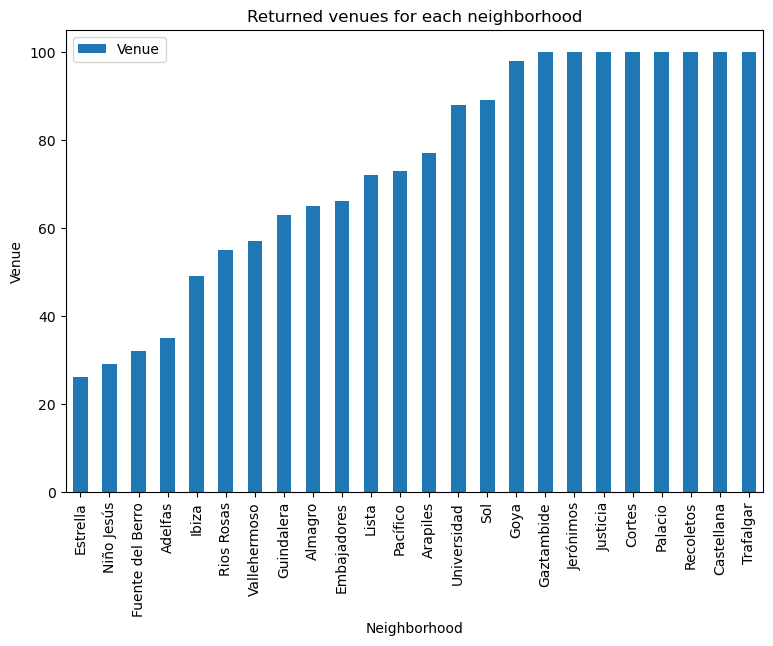

In [104]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

center_venues_bar.plot(kind='bar', figsize=(9, 6))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Venue') # add y-label to the plot
plt.title('Returned venues for each neighborhood') # add title to the plot

plt.show()

Let's find out how many unique categories can be curated from all the returned venues.

In [75]:
print('There are {} uniques categories.'.format(len(center_venues['Venue Category'].unique())))

There are 206 uniques categories.


### Analyze Each Neighborhood

In [78]:
# one hot encoding
center_onehot = pd.get_dummies(center_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
center_onehot.drop(['Neighborhood'],axis=1,inplace=True) 
center_onehot.insert(loc=0, column='Neighborhood', value=center_venues['Neighborhood'] )

center_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Burrito Place,Bus Station,Café,Camera Store,Casino,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Shop,Donut Shop,Dumpling Restaurant,Electronics Store,Embassy / Consulate,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Stand,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Office,Opera House,Optical Shop,Other Event,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Piano Bar,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pub,Public Art,Ramen Restaurant,Resort,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Justicia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Justicia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Justicia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

And let's examine the new dataframe size.

In [79]:
center_onehot.shape

(1774, 206)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [80]:
center_grouped = center_onehot.groupby('Neighborhood').mean().reset_index()
center_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Burrito Place,Bus Station,Café,Camera Store,Casino,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Shop,Donut Shop,Dumpling Restaurant,Electronics Store,Embassy / Consulate,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Stand,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Office,Opera House,Optical Shop,Other Event,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Piano Bar,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pub,Public Art,Ramen Restaurant,Resort,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Adelfas,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.028571,0.0,0.00,0.028571,0.057143,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.028571,0.00,0.000000,0.028571,0.028571,0.000000,0.0,0.028571,0.000000,0.028571,0.028571,0.0,0.00,0.0,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.028571,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,0.028571,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,0.0,0.085714,0.0,0.028571,0.0,0.028571,0.00,0.000000,0.000000,0.0,0.00,0.0,0.028571,0.000000,0.0,0.00,0.0,0.028571,0.0,0.00,0.0,0.00,0.057143,0.057143,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.057143,0.00,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.00,0.00,0.0,0.0,0.028571,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.028571,0.000000,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.028571,0.0,0.0,0.00,0.028571,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.00,0.00,0.000000,0.00,0.028571,0.0,0.000000,0.000000,0.00,0.0,0.0,0.00,0.000000,0.028571,0.0,0.00,0.000000,0.028571,0.00,

Let's confirm the new size.

In [81]:
center_grouped.shape

(24, 206)

Let's print each neighborhood along with the top 5 most common venues.

In [82]:
num_top_venues = 5

for hood in center_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = center_grouped[center_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelfas----
                  venue  freq
0  Fast Food Restaurant  0.09
1         Grocery Store  0.06
2           Supermarket  0.06
3                 Hotel  0.06
4                   Gym  0.06


----Almagro----
                venue  freq
0          Restaurant  0.12
1  Spanish Restaurant  0.09
2               Plaza  0.05
3                 Bar  0.05
4  Italian Restaurant  0.05


----Arapiles----
                venue  freq
0  Spanish Restaurant  0.10
1                 Bar  0.08
2                Café  0.06
3              Bakery  0.06
4    Tapas Restaurant  0.05


----Castellana----
                venue  freq
0  Spanish Restaurant  0.16
1          Restaurant  0.10
2            Boutique  0.08
3         Coffee Shop  0.06
4    Tapas Restaurant  0.05


----Cortes----
        venue  freq
0        Café  0.07
1         Bar  0.07
2       Plaza  0.06
3       Hotel  0.06
4  Restaurant  0.05


----Embajadores----
              venue  freq
0               Bar  0.08
1  Tapas Restaurant  0.06
2    

Let's put that into a pandas dataframe.

First, let's write a function to sort the venues in descending order.

In [83]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [84]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = center_grouped['Neighborhood']

for ind in np.arange(center_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(center_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelfas,Fast Food Restaurant,Supermarket,Bar,Hotel,Grocery Store,Gym,Bookstore,Spanish Restaurant,Breakfast Spot,Brewery
1,Almagro,Restaurant,Spanish Restaurant,Italian Restaurant,Bar,Plaza,Nightclub,Pub,Breakfast Spot,Salad Place,Café
2,Arapiles,Spanish Restaurant,Bar,Café,Bakery,Tapas Restaurant,Burrito Place,Hotel,Restaurant,Sandwich Place,Multiplex
3,Castellana,Spanish Restaurant,Restaurant,Boutique,Coffee Shop,Tapas Restaurant,Mediterranean Restaurant,Japanese Restaurant,Gym / Fitness Center,Bar,Seafood Restaurant
4,Cortes,Bar,Café,Plaza,Hotel,Restaurant,Tapas Restaurant,Mediterranean Restaurant,Spanish Restaurant,Market,Pizza Place


### Cluster Neighborhoods

For cluster analysis we have to partition the data set into k clusters. First, we need to find an optimal value of k in K-means. For this reason I use the Elbow method as a type of unsupervised learning and one of the popular methods of clustering unlabeled data into k clusters.

In [85]:
# set random number of clusters

kclusters = 3

center_grouped_clustering = center_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(center_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([1, 2, 0, 2, 0, 0, 1, 1, 0, 2, 1, 2, 2, 0, 2, 1, 1, 0, 2, 0, 0, 0,
       0, 1])

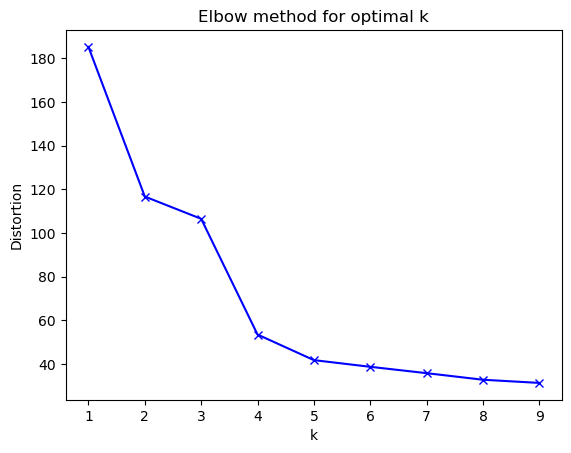

In [87]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(center_grouped_clustering)
    kmeanModel.fit(center_grouped_clustering)
    distortions.append(sum(np.min(cdist(center_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / center_grouped_clustering.shape[0])

#There are different metric distance function for spatial distance. 
#I choose correlation instaed of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow method for optimal k')
plt.show()

In the plot above the elbow is at k=5 indicating the optimal k for this dataset is 5.

In [88]:
# set number of clusters
kclusters = 5

center_grouped_clustering = center_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(center_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 1, 2, 1, 2, 2, 4, 0, 2, 1])

Let's create a new data frame that includes the clusters as well as the top 10 venues for each neighborhood.

In [89]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

center_merged = center_data

# merge center_grouped with center_data to add latitude/longitude for each neighborhood
center_merged = center_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

center_merged.head() # check the last columns!

,District,Neighborhood,Price,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Centro,Justicia,5983,40.423889,-3.696389,2,Bakery,Spanish Restaurant,Restaurant,Hotel,Bookstore,Deli / Bodega,Flower Shop,Vegetarian / Vegan Restaurant,Lounge,Bistro
1,Centro,Cortes,5159,40.414167,-3.698056,2,Bar,Café,Plaza,Hotel,Restaurant,Tapas Restaurant,Mediterranean Restaurant,Spanish Restaurant,Market,Pizza Place
2,Centro,Embajadores,4455,40.408889,-3.699722,2,Bar,Tapas Restaurant,Café,Spanish Restaurant,Market,Bookstore,Restaurant,Pizza Place,Art Gallery,Sushi Restaurant
3,Centro,Universidad,5337,40.425278,-3.708333,2,Café,Bookstore,Hotel,Spanish Restaurant,Plaza,Tapas Restaurant,Cocktail Bar,Bar,Theater,Peruvian Restaurant
4,Centro,Palacio,4800,40.415000,-3.713333,0,Tapas Restaurant,Spanish Restaurant,Plaza,Bar,Restaurant,Church,Vegetarian / Vegan Restaurant,Mediterranean Restaurant,Mexican Restaurant,Cocktail Bar


We can visualize a number and a kind of venues in clusters so that it is easier to label each of them.

In [90]:
count_venue = center_merged
count_venue = count_venue.drop(['District', 'Neighborhood', 'Price', 'Latitude', 'Longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,Bakery,Bar,Café,Fast Food Restaurant,Park,Plaza,Restaurant,Spanish Restaurant,Tapas Restaurant
0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,3,7,0
2,1,2,1,0,0,1,1,3,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0


Text(0, 0.5, 'Clusters')

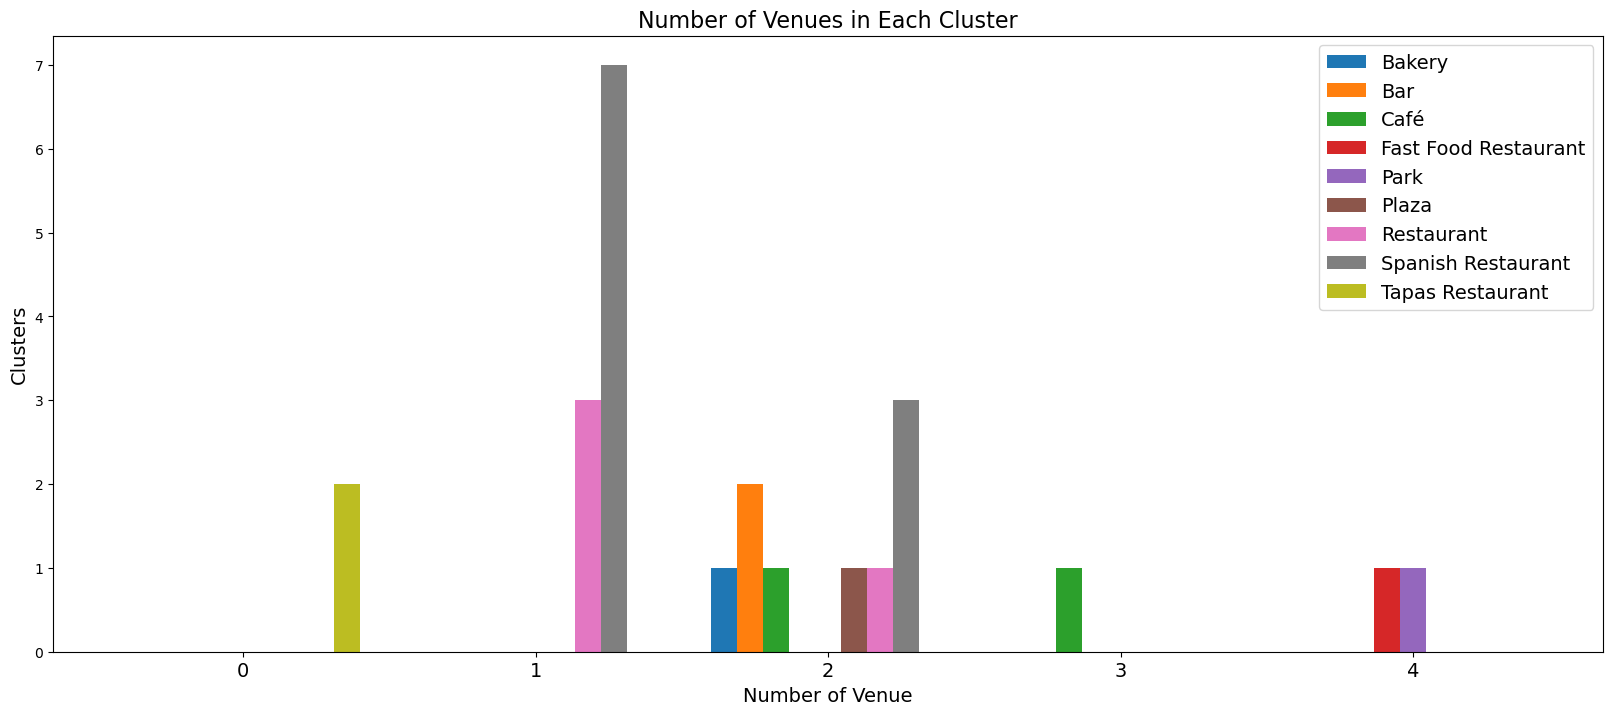

In [91]:
#creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Number of Venue', fontsize=14)
plt.ylabel('Cluster', fontsize=14)

After examining the bar chart, we can name each label as follows:

Cluster 0: Tapas Restaurants

Cluster 1: Restaurants

Cluster 2: Bars/Eating Establishments/Hotels

Cluster 3: Cafes

Cluster 4: Fast Food Restaurants/Park

In [107]:
Cluster_labels = {'Clusters': [0,1,2,3,4], 'Labels': ["Tapas Restaurants","Restaurants","Bars/Eating Establishments/Hotels","Cafes","Fast Food Restaurants/Park"]}
Cluster_labels = pd.DataFrame(data=Cluster_labels)
Cluster_labels

,Clusters,Labels
0,0,Tapas Restaurants
1,1,Restaurants
2,2,Bars/Eating Establishments/Hotels
3,3,Cafes
4,4,Fast Food Restaurants/Park


Let´s show top 3 venues for each neighborhood on the map. To do this we group each neighborhood by the number of top 3 venues in "Top 3 venues" column.

In [108]:
top3 = center_venues.groupby(['Neighborhood','Venue Category']).size().reset_index(name='Counts')
top3 = top3.sort_values(['Neighborhood','Counts'],ascending=False).groupby('Neighborhood').head(3).reset_index(drop=True)

top3['Top 3 venues'] = top3['Counts'].map(str) + " " + top3['Venue Category']
top3 = top3.groupby(['Neighborhood'])['Top 3 venues'].apply(", ".join).reset_index()

top3.head()

,Neighborhood,Top 3 venues
0,Adelfas,"3 Fast Food Restaurant, 2 Bar, 2 Grocery Store"
1,Almagro,"8 Restaurant, 6 Spanish Restaurant, 3 Bar"
2,Arapiles,"8 Spanish Restaurant, 6 Bar, 5 Bakery"
3,Castellana,"16 Spanish Restaurant, 10 Restaurant, 8 Boutique"
4,Cortes,"7 Bar, 7 Café, 6 Hotel"


## Results

### Final results table

Let's merge those new variables with related cluster information in our result table.

In [109]:
result = pd.merge(center_merged, 
                    top3[['Neighborhood', 'Top 3 venues']],
                    left_on = 'Neighborhood',
                    right_on = 'Neighborhood',
                    how = 'left')
result= pd.merge(result, 
                    Cluster_labels[['Clusters', 'Labels']],
                    left_on = 'Cluster Labels',
                    right_on = 'Clusters',
                    how = 'left')


result = result.drop(['Clusters'], axis=1)
result.head()

,District,Neighborhood,Price,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Top 3 venues,Labels
0,Centro,Justicia,5983,40.423889,-3.696389,2,Bakery,Spanish Restaurant,Restaurant,Hotel,Bookstore,Deli / Bodega,Flower Shop,Vegetarian / Vegan Restaurant,Lounge,Bistro,"7 Bakery, 6 Restaurant, 6 Spanish Restaurant",Bars/Eating Establishments/Hotels
1,Centro,Cortes,5159,40.414167,-3.698056,2,Bar,Café,Plaza,Hotel,Restaurant,Tapas Restaurant,Mediterranean Restaurant,Spanish Restaurant,Market,Pizza Place,"7 Bar, 7 Café, 6 Hotel",Bars/Eating Establishments/Hotels
2,Centro,Embajadores,4455,40.408889,-3.699722,2,Bar,Tapas Restaurant,Café,Spanish Restaurant,Market,Bookstore,Restaurant,Pizza Place,Art Gallery,Sushi Restaurant,"5 Bar, 4 Café, 4 Tapas Restaurant",Bars/Eating Establishments/Hotels
3,Centro,Universidad,5337,40.425278,-3.708333,2,Café,Bookstore,Hotel,Spanish Restaurant,Plaza,Tapas Restaurant,Cocktail Bar,Bar,Theater,Peruvian Restaurant,"6 Café, 5 Bookstore, 5 Hotel",Bars/Eating Establishments/Hotels
4,Centro,Palacio,4800,40.415000,-3.713333,0,Tapas Restaurant,Spanish Restaurant,Plaza,Bar,Restaurant,Church,Vegetarian / Vegan Restaurant,Mediterranean Restaurant,Mexican Restaurant,Cocktail Bar,"20 Tapas Restaurant, 11 Spanish Restaurant, 8 ...",Tapas Restaurants


### Clusters visualization

Visualize the resulting clusters.

In [110]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, join, cluster_number in zip(result['Latitude'], result['Longitude'], result['Neighborhood'], result['Labels'], result['Top 3 venues'], result['Cluster Labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + " / " + str(join), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color= rainbow[cluster_number-1],
        popup=label,
        fill_color = rainbow[cluster_number-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

### Housing sale prices with clusters superimposed on top

One of my goals was to visualize average housing sale prices per m2 using choropleth map. For this reason, I use json file to visualize neighborhood divisions on the map and then join it with clusters map. 

In [99]:
from urllib.request import urlopen

with urlopen('https://gist.githubusercontent.com/Saigesp/8ca8ca2a4ce33e8e9efe8f5752683f88/raw/81d61ae9a410a59cb512dd7b01ba9bd5c98c8380/ESP_MAD_adm6.json') as response:
    neigh = json.load(response)

In [111]:
madrid_map = folium.Map(location=[40.4167047, -3.7035825], zoom_start=13, tiles='Mapbox Bright')

In [112]:
madrid_map.choropleth(
    geo_data=neigh,
    data=data,
    columns=['Neighborhood', 'Price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='House sale price in Madrid in April, 2020',
    highlight=True
)

markers_colors = []
for lat, lon, poi, cluster, join, cluster_number in zip(result['Latitude'], result['Longitude'], result['Neighborhood'], result['Labels'], result['Top 3 venues'], result['Cluster Labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + " / " + str(join), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color= rainbow[cluster_number-1],
        fill=True,
        popup=label,
        fill_color = rainbow[cluster_number-1],
        fill_opacity=1).add_to(madrid_map)

# display map
madrid_map

C:\Users\Ramon y Anna\anaconda3\envs\First\lib\site-packages\folium\folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


## Discussion

The given analysis of Madrid neighborhoods was performed based on the housing sale prices of Madrid in April 2020 and venues density in the neighborhoods. For the project, I have utilized four data resources and two machine learning methods such as one-hot encoding and K-means. In addition, I have combined location data to explore a geographical location with visualization of geospatial data.

Housing sale prices and venues density data analysis could also be performed for the rest of the neighborhoods or based on more accurate parameters such as the number of venues and radius for segmenting them or even coordinates to explore the streets, for instance. 

Also, venues density used for the project was one of the examples of choosing a real estate property and of course, the analysis could also be executed for another type of clusters. Comparison between housing sales pricing and, for instance, educational institutions, transport, or grocery shops accessibility could be another option to consider.

Certainly, this would depend on the purposes of the project and interested audience.


## Conclusion

Madrid has a total of 21 districts and 131 neighborhoods. Housing sale prices vary across the neighborhoods. The center city neighborhoods have the highest cost per square meter and the neighborhoods in the south have the lowest cost. There is also a significant difference between the north and the south of the city, being the north more expensive than the south.

The average price of second-hand housing in the Spanish capital in April 2020 is 3.436 €/m2. Recoletos, in Salamanca district, with 8.440 €/m2 and San Cristobal, in Villaverde district, with 1.400 €/m2 have the maximum and minimum cost per square meter respectively. 

For analysis and segmenting only 24 neighborhoods out of 131 were left and only 8 of them reached the venues limit of 100, 4 are below 40 venues per neighborhood. The number of unique categories that can be curated from all the returned venues is 206. 

Due to the Elbow method, all the venues were clustered in 5 clusters with the following given names: Tapas Restaurants, Restaurants, Bars/Eating Establishments/Hotels, Cafes, Fast Food Restaurants/Park. 

As a result, each neighborhood has information about its average sale price, cluster name, and top venues in it.

The obtained result can be useful for investors in making decisions in purchasing real estate property in Madrid. 

## References

[1] [Madrid - wikipedia.org](https://en.wikipedia.org/wiki/Madrid)

[2] [Average price of second-hand housing by Neighborhood - idealista.com](https://www.idealista.com/sala-de-prensa/informes-precio-vivienda/venta/madrid-comunidad/madrid-provincia/madrid/)

[3] [Coordinates of each Neighborhood - tools.wmflabs.org/geohack](https://tools.wmflabs.org/geohack/geohack.php?params=40.418888888889_N_-3.6919444444444_E_globe:earth&language=en)

[4] [Top venues - developer.foursquare.com](https://developer.foursquare.com/)

[5] [Neighborhood divisions - gist.github.com/Saigesp](https://gist.github.com/Saigesp/8ca8ca2a4ce33e8e9efe8f5752683f88)
